In [1]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data
def ldata2(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append([col[0],col[1]])
    return data
def ldata3(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col[1])
    return data

In [2]:


import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

red_proteinas=ldata("tc02Data/yeast_AP-MS.txt")
red_binarias=ldata("tc02Data/yeast_Y2H.txt")
red_literatura=ldata("tc02Data/yeast_LIT.txt")
Esencialidad=ldata3("tc02Data/Essential_ORFs_paperHe.txt")
red_litreguly=ldata2("tc02Data/yeast_LIT_Reguly.txt")



In [3]:
G = nx.Graph()#directed
G.add_edges_from(red_proteinas)
G1 = nx.Graph()#directed
G1.add_edges_from(red_binarias)
G2 = nx.Graph()#directed
G2.add_edges_from(red_literatura)
G3 = nx.Graph()#directed
G3.add_edges_from(red_litreguly)

In [4]:
def K(H):
    k=sum(H.degree(k) for k in H)/H.number_of_nodes()
    salida=[k]
    return salida

In [5]:
data = pd.DataFrame({"Red":["Proteinas","Binarias","Literatura", "Literatura Reg."],
                     "Número de Nodos":[G.number_of_nodes(),G1.number_of_nodes(),G2.number_of_nodes(), G3.number_of_nodes()],
                     "Número de Enlaces":[G.number_of_edges(),G1.number_of_edges(),G2.number_of_edges(),G3.number_of_edges()],
                 "Grado medio ":[K(G),K(G1),K(G2),K(G3)],
                 "Clustering promedio":[nx.average_clustering(G),nx.average_clustering(G1),nx.average_clustering(G2),nx.average_clustering(G3)] })
cols= ['Red', 'Número de Nodos', 'Número de Enlaces', 'Grado medio ','Clustering promedio']

data[cols]


,Red,Número de Nodos,Número de Enlaces,Grado medio,Clustering promedio
0,Proteinas,1622,9070,[11.183723797780518],0.554636
1,Binarias,2018,2930,[2.9038652130822595],0.046194
2,Literatura,1536,2925,[3.80859375],0.292492
3,Literatura Reg.,3309,11859,[7.167724388032639],0.260976


In [6]:
def overlap(J,K):
    a=0
    for j in nx.edges(J):
        for i in nx.edges(K):
            if i==j or i[0]==j[1] and i[1]==j[0]:
                a+=1 
                
    return a/nx.number_of_edges(J), a/nx.number_of_edges(K) 

In [7]:
overlap(G1,G2)

(0.08873720136518772, 0.08888888888888889)

In [8]:
p1=ldata("tc02Data/prueba1.txt")
p2=ldata("tc02Data/prueba2.txt")

FileNotFoundError: [Errno 2] No such file or directory: 'tc02Data/prueba1.txt'

In [ ]:
P1=nx.Graph(p1)
P2=nx.Graph(p2)


In [ ]:
overlap(P1, P2)

In [ ]:
def NodosEsencialesGrado(J,K):
    NE=[]
    k=[]
    for i in nx.nodes(J):
        for j in K:
            if i==j:
                NE.append(i)
                k.append(J.degree(i))
    return k, NE    

In [ ]:
def Histograma(J,K):  
    F=NodosEsencialesGrado(J,K)
    plt.hist(F[0],bins=max(F[0]))
    plt.title("Histograma")
    return plt.show()

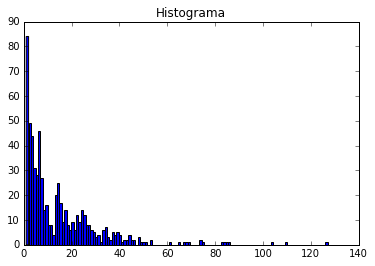

In [62]:
Histograma(G,Esencialidad)

In [64]:
def Zotenko(Grafo,Lista):
    ###Acá seteamos los esenciales y le damos su grado
    #NE=[]
    k=[]
    for i in nx.nodes(Grafo):
        for j in Lista:
            if i==j:
                #NE.append(i)
                k.append(Grafo.degree(i))
    #k_NE=[k,NE]
    
    ###Seteamos todos los nodos y su grado
    #N=[]
    K=[]
    for i in nx.nodes(Grafo):
        #N.append(i)
        K.append(Grafo.degree(i))
    #k_N=[K,N]
    
    ###Número de hubbs (normalizado) y k0
    A=[]
    #ko=[]
    B=[]
    for k0 in set(K):
        a=0
        for i in K:
            if i>=k0:
                a+=1
        A.append(a/nx.number_of_nodes(Grafo))
        #ko.append(k0)
        ###El eje y  
        b=0
        for l in k:
            if l>=k0:
                b+=1
        B.append(b/a)
    
    return A,B

In [69]:
Ñ=Zotenko(G,Esencialidad)
Ñ1=Zotenko(G1,Esencialidad)
Ñ2=Zotenko(G2,Esencialidad)
Ñ3=Zotenko(G3,Esencialidad)

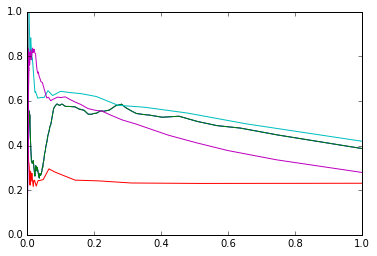

In [70]:
plt.plot(Ñ[0],Ñ[1])
plt.plot(Ñ1[0],Ñ1[1])
plt.plot(Ñ2[0],Ñ2[1])
plt.plot(Ñ3[0],Ñ3[1])
plt.show()

In [9]:
##Habría que trabajar con la componente gigante como el paper
